<font size="+5">Table of Contents </font>

1) [Loading and viewing dataset](#Imports-and-loading-data)<br>
2) [Joining tables](#Joins)<br>
3) [Correlation between features and legendary](#Which-numerical-features-are-most-highly-correlated-with-a-Pokémon-being-legendary?)<br>
4) [kNN Classification](#kNN-classification)<br>
5) [Logistic Regression](#Logistic-regression)<br>
6) [SMOTE (Synthetic Minority Over Sampling Technique)](#Overcoming-the-obstacle-using-SMOTE-(Synthetic-Minority-Over-Sampling-Technique)-with-Imbalanced-Learn)<br>

# Imports and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             classification_report,
                             #plot_confusion_matrix,
                             ConfusionMatrixDisplay)

import imblearn

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
pkmn = pd.read_csv('./pokemon_data/Pokemon_with_correct_pkmn_numbers.csv')
pkmn.rename(columns=(
                    {'#':'Pokemon ID', 'Total':'Total Stats'}),
            inplace=True)
# Usually rows in a Pandas dataframe (df) start at 0, but Pokemon IDs 
# start at 1.  The next line of code makes the df row index start at 1 
# and this will help us with joins later.  (joining pkmn and combats tables)
pkmn.index = pkmn.index + 1

combats = pd.read_csv("./pokemon_data/combats.csv")

## Pokemon table

In [3]:
pkmn.head()

,Pokemon ID,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Note that values in the Number column are not unique, as pokemon like Venusaur and Mega Venusaur both have Number 3, but their row index is unique.  This is important bc our combats data keeps track of winners using a pokemon's row index, NOT its Pokemon ID.  

In [4]:
print(F"The pkmn df has row index starting at {pkmn.index.min()} and ending at {pkmn.index.max()}")
print(F"While the min pkmn. Number is {pkmn['Pokemon ID'].min()} and the max pkmn.Number is {pkmn['Pokemon ID'].max()}")

The pkmn df has row index starting at 1 and ending at 800
While the min pkmn. Number is 1 and the max pkmn.Number is 721


Further proof that pokemon numbers are NOT unique, while row indexes are unique.

## Combats Table

In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
combats['Winner'].describe()

count    50000.000000
mean       408.890100
std        231.159961
min          1.000000
25%        206.000000
50%        422.000000
75%        606.000000
max        800.000000
Name: Winner, dtype: float64

Looking at our combats data, our max number for Winner is 800.  This is because a winning pokemon is identified by the row index in the pkmn df.  Winner DOES NOT correspond to pkmn Number.

# Joins

## Identify names of pokemon in winning battles

In [7]:
# Join combats to pkmn table using the unique row indices (1, 800) 
# for the pkmn table.  This ensures that a pokemon like 
# Venusaur vs. Mega Venusaur will each have their own row 
# and appropriate number of wins. 
combats_join = pd.merge(combats, 
                        pkmn[['Name']], left_on='Winner', 
                        right_index=True, 
                        how='left')
combats_join.rename(columns={'Name':"winner_name"}, inplace=True)
combats_join.head()

,First_pokemon,Second_pokemon,Winner,winner_name
0,266,298,298,Nuzleaf
1,702,701,701,Terrakion
2,191,668,668,Beheeyem
3,237,683,683,Druddigon
4,151,231,151,Omastar


## Identifying number of wins for each pokemon from battles data

The pkmn table contains all pokemon, however the combats table only has pokemon that were used in a battle.  There are many pokemon that weren't used in combat and the combats table has no data on.  To preserve all 800 unique Pokemon from pkmn table after the join, we need to use a left join.  Any Pokemon that aren't found in the right df (winners) will get a NaN value that we'll replace with 0.

In [8]:
winners = combats_join['Winner'].value_counts()
pkmn_join = pd.merge(pkmn, winners, 
                     how='left', 
                     left_index=True, 
                     right_index=True)
pkmn_join.rename(mapper={'Winner':'Wins'}, 
                 axis=1, 
                 inplace=True)
# If a pokemon has NaN for Wins, we have no data on combats 
# for the pokemon and can be considered as having 0 wins.
pkmn_join['Wins'].fillna(value=0, inplace=True)
pkmn_join.sort_values('Wins', ascending=False)

,Pokemon ID,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins
163,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,152.0
154,142,Aerodactyl,Rock,Flying,515,80,105,65,60,75,130,1,False,136.0
438,392,Infernape,Fire,Fighting,534,76,104,71,104,71,108,4,False,136.0
428,385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True,134.0
314,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,556,Maractus,Grass,NaN,461,75,86,67,106,67,60,5,False,0.0
183,168,Ariados,Bug,Poison,390,70,90,70,60,60,40,2,False,0.0
322,297,Hariyama,Fighting,NaN,474,144,120,60,40,60,50,3,False,0.0
66,60,Poliwag,Water,NaN,300,40,50,40,40,40,90,1,False,0.0


In [9]:
# Check to see if join was done correctly
num_combats = len(combats)
total_wins = pkmn_join['Wins'].sum()

print(num_combats == total_wins)

True


It looks like all the data was joined correctly

In [10]:
pkmn_join.to_csv("./pokemon_data/pkmn_join.csv")

# Which numerical features are most highly correlated with a Pokémon being legendary?

## Pairplots of variables

In [11]:
pkmn_corr = pkmn_join.corr()

In [12]:
most_corr_num_features = pkmn_corr['Legendary'].sort_values(ascending=False)[1:7].index.values

In [13]:
# sns.pairplot(pkmn_join[
#                             ['Total Stats',
#                              'Sp. Atk', 
#                              'Sp. Def', 
#                              'Attack', 
#                              'Speed', 
#                              'Wins', 
#                              'Legendary']
#                             ], 
#                              hue='Legendary');

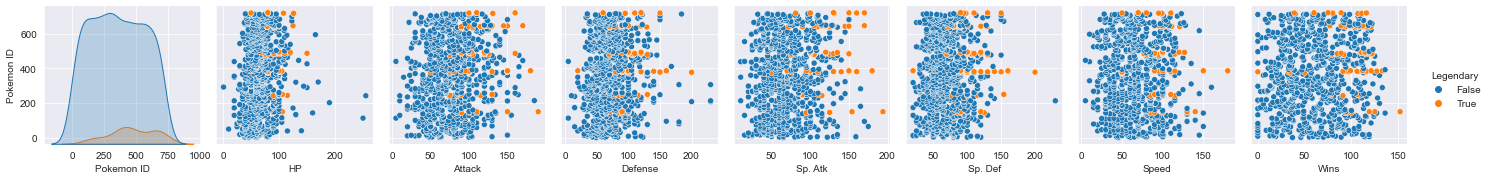

In [14]:
new_df = pkmn_join[['Pokemon ID',
                    'HP',
                    'Attack',
                    'Defense',
                    'Sp. Atk',
                    'Sp. Def',
                    'Speed',
                    'Wins',
                    'Legendary']]

sns.pairplot(data=new_df, 
             hue='Legendary',
             y_vars='Pokemon ID')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/pairplots.png");

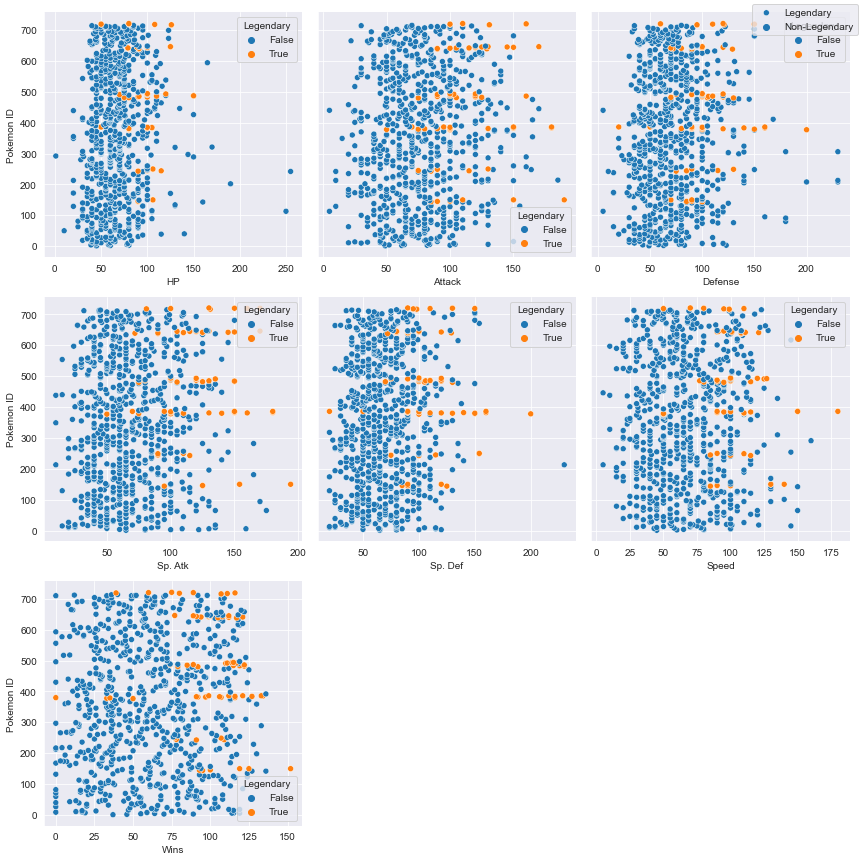

In [15]:
features_names = ['HP',
               'Attack',
               'Defense',
               'Sp. Atk',
               'Sp. Def',
               'Speed',
               'Wins',
               'Legendary']

X = pkmn_join[features_names].copy(deep=True)
y = pkmn_join[['Pokemon ID']].copy(deep=True)


data = pd.concat([X, y], axis=1)


y_name = 'Pokemon ID'
#features_names = [f'feature_{i}' for i in range(1, X.shape[1]+1)]  
#column_names = features_names + [y_name]
#data.columns = column_names

plot_size=6
num_plots_x=3   # No. of plots in every row
num_plots_y = math.ceil((X.shape[1]-1)/num_plots_x)   # No. of plots in y direction

'''
for i in range(num_plots_y):
    start = i * num_plots_x
    end = start + num_plots_x
    sns.pairplot(x_vars=features_names[start:end], y_vars=y_name, data=data)
'''

g = sns.FacetGrid(pd.DataFrame(features_names[:-1]), col=0, col_wrap=3, sharex=False, height=4, aspect=1)
for ax, x_var in zip(g.axes, features_names[:-1]):
    sns.scatterplot(data=data, x=x_var, y=y_name, ax=ax, hue='Legendary', legend=True)

    
legend_labels  = ['Legendary', 'Non-Legendary']
    
    
g.tight_layout()

current_fig = plt.gcf()

current_fig.legend(labels=legend_labels)


#g.add_legend(legend_data={'Legendary':'a', 'Non-Legendary':'b'})
plt.savefig('/Users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/scatterplots1.png', bbox_inches='tight')
plt.show()

For all plots, we see a tendency for legendary Pokémon to cluster in the right side of each scatter plot, indicating that legendary Pokémon tend to have high stats as compared to non-legendary pokemon.  These predictors are probably going to be the most important for our model's performance.

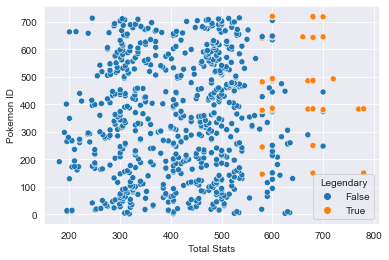

In [16]:
new_df = pkmn_join[['Pokemon ID',
                    'Total Stats',
                    'Legendary']]

sns.scatterplot(data=new_df, 
             hue='Legendary',
             y='Pokemon ID',
             x='Total Stats')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/pairplot_total_stats.png");

Because this tendency was true for all individual stats, I was curious to see what would happen if a new feature called `Total Stats` was created, which is the sum of `HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, and `Speed`.

When plotting the new feature Total Stats, it's much easier to see that legendary Pokémon tend to have higher `Total Stats` than non-legendary Pokémon.  While we don't see perfect separation between the groups, the decision boundary is much more clear than any of the scatter plots that focused on just a single Pokémon stat.

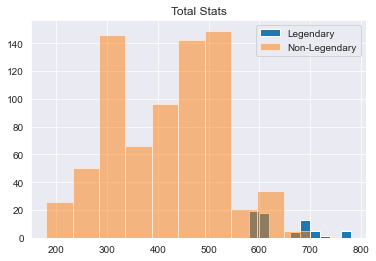

In [17]:
fig, ax = plt.subplots(1,1)
pkmn_join[pkmn_join['Legendary']==True].hist(column='Total Stats', 
                                                       ax=ax)
pkmn_join[pkmn_join['Legendary']==False].hist(column='Total Stats', 
                                                        ax=ax, alpha=0.5)
plt.legend(['Legendary', 'Non-Legendary'])
plt.show();

Focusing on the aggregated total stats, we see legendary pokemon are towards the top.  I expect this predictor will be very useful in our model.

## Heatmaps of Correlation against Legendary

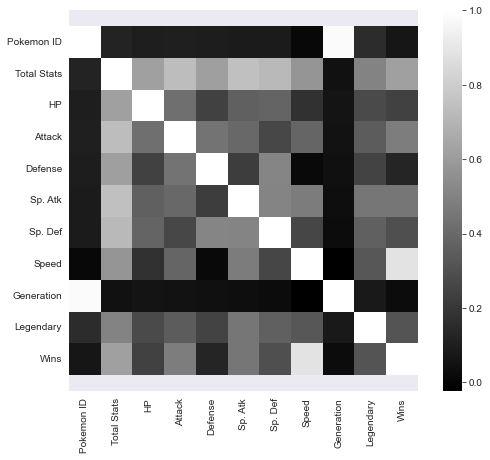

In [18]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
sns.heatmap(pkmn_corr, 
            cmap='gist_gray', 
            square=True, 
            ax=ax
            #, annot=True, fmt='.2f', annot_kws={'size':12}
           )
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show();

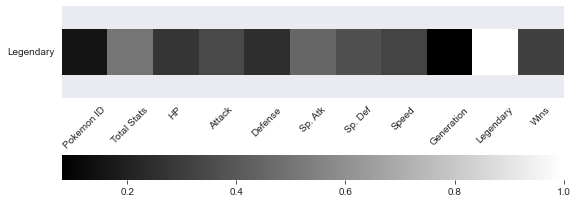

In [19]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
sns.heatmap(pkmn_corr[['Legendary']].T, 
            cmap='gist_gray', 
            square=True, 
            ax=ax,
            cbar_kws={"orientation": "horizontal"}
            #, annot=True, fmt='.2f', annot_kws={'size':12}
           )
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/heatmap.png')
plt.show();

In [20]:
pkmn_corr['Legendary'].sort_values(ascending=False)

Legendary      1.000000
Total Stats    0.501758
Sp. Atk        0.448907
Sp. Def        0.363937
Attack         0.345408
Speed          0.326715
Wins           0.312999
HP             0.273620
Defense        0.246377
Pokemon ID     0.153396
Generation     0.079794
Name: Legendary, dtype: float64

Legendary seems most highly correlated with the individual stats `Sp. Atk`, `Sp. Def`, `Attack`, and `Speed`, however we see the highest correlation with `Total Stats`.  

Legendary is also somewhat correlated with `Wins`.

# kNN classification
Predicting legendary status from pokemon stats (HP, Defense, ..., num_wins_in_combat)

In [21]:
pkmn_join_copy = pkmn_join.copy(deep=True)

numeric_cols_labels = ['Total Stats', 
                       'HP', 'Attack', 
                       'Defense', 
                       'Sp. Atk', 
                       'Sp. Def', 
                       'Speed', 
                       'Wins']

numeric_cols = pkmn_join_copy.loc[:, numeric_cols_labels]

## Scale and transform the data

kNN classification requires quantitative values as input.  For categorical data, we can convert to dummy variables, which are quantitative, and allow for the use of categorical data in the model. 

Note, I decide to exclude the "Generation" column.  I want the model to work without knowing which generation a pokemon comes from because I want the model to be generalizable to future generations of pokemon as well.  Lataer, I plan to test the model's performance on generation 8 pokemon.

In [22]:
categorical_cols = pkmn_join_copy.loc[:, ['Type 1', 'Type 2']]
categorical_cols_labels = list(categorical_cols.columns)
orig_with_dummies = pd.get_dummies(
                                    pkmn_join.drop(
                                        ['Pokemon ID', 'Name', 'Legendary'], 
                                        axis=1), 
                                    columns=categorical_cols_labels
                                    )

kNN classification compares Euclidean distance between points when classifying a prediction.  Some of our numeric values are on a larger scale than others, which will have an impact on Euclidean distance, and may skew our understanding of the strength of a given predictor in the model.  To overcome this issue, we transform our numeric data so all predictors are on the same scale.

In [23]:
scaled_with_dummies = orig_with_dummies.copy()

scaler = StandardScaler()
scaler.fit(numeric_cols)
scaled_with_dummies.loc[:, numeric_cols_labels] = scaler.transform(numeric_cols)

In [24]:
# scaled_with_dummies = orig_with_dummies.copy()

Lastly, we separate our target labels from the rest of the dataset

In [25]:
target_df = pkmn_join_copy['Legendary']

### Checking the results

In [26]:
scaled_with_dummies.head()

,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Type 1_Bug,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,-0.976765,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,-0.753747,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.251088,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,-0.487719,0,...,0,0,0,0,0,1,0,0,0,0
3,0.749845,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,0.783306,0,...,0,0,0,0,0,1,0,0,0,0
4,1.583957,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,0.221690,0,...,0,0,0,0,0,1,0,0,0,0
5,-1.051836,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,-0.221690,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
scaled_with_dummies.columns

Index(['Total Stats', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation', 'Wins', 'Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug',
       'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy',
       'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost',
       'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water'],
      dtype='object')

## Building Models

First, I'm going to consider building a model that uses each stat.  The extra granularity may help build a better model, but it will be more complex as a result.  I'll first start using all available features, but then see what happens when I narrow down to focusing on the numerical values that are most highly correlated with legendary: Sp. Atk, Sp. Def, Attack, Speed, and Wins.  I'm also especially interested in how well the model performs if I only use the `Total Stats` predictor.

### Creating a model using all features except total stats.

In [28]:
# Drop Total Stats column as we have more granularity 
# if we look at each stat individually.  We can consider 
# building a model that looks at total stats later on and 
# compare performance to the model we build now.
scaled_with_dummies_no_total = scaled_with_dummies.drop('Total Stats', 
                                                        axis=1)

In [29]:
scaled_with_dummies_no_total.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,-0.753747,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,-0.487719,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,0.783306,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,0.221690,0,0,...,0,0,0,0,0,1,0,0,0,0
5,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,-0.221690,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Which n_neighbors is most optimal and what is the performance?

In [30]:
knn_all_features_no_total = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(3,101,2)}

knn_all_features_no_total_gscv = GridSearchCV(knn_all_features_no_total, 
                                              param_grid, cv=5)
knn_all_features_no_total_gscv.fit(scaled_with_dummies_no_total, 
                                   target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_no_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_no_total_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 19}
Highest model performance: 0.9362499999999999


This will establish our baseline.  Let's see if we can build a model that is less complex and performs better.

### Creating a model which swaps HP, Attack, Defense, Sp. Attack, and Sp. Defense for their aggregate `Total Stats`.

In [31]:
stats_labels = numeric_cols_labels[1:]
scaled_with_dummies_total = scaled_with_dummies.drop(stats_labels, 
                                                     axis=1)

#### Which n_neighbors is most optimal and what is the performance?

In [32]:
knn_all_features_with_total = KNeighborsClassifier()

knn_all_features_with_total_gscv = GridSearchCV(knn_all_features_with_total, 
                                                param_grid, cv=5)
knn_all_features_with_total_gscv.fit(scaled_with_dummies_total, 
                                     target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_with_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_with_total_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 41}
Highest model performance: 0.925


Now the most optimal model for this new set of predictors sees worse performance and is more complex, with an optimal n_neighbors of 41.  I'd be a little concerned this model is overfitting.

### Creating a model using the predictors that were highly correlated with `Legendary`: `Total Stats`, `Sp. Atk`, `Sp. Def`, `Attack`, `Speed`, and `Wins`

In [33]:
individual_stats_and_wins = scaled_with_dummies[
                                                ['Sp. Atk', 
                                                 'Sp. Def', 
                                                 'Attack', 
                                                 'Speed', 
                                                 'Wins']
                                                ]

#### Which n_neighbors is most optimal and what is the performance?

In [34]:
knn_individual_stats_and_wins = KNeighborsClassifier()

knn_individual_stats_and_wins_gscv = GridSearchCV(knn_individual_stats_and_wins, 
                                                  param_grid, 
                                                  cv=5)
knn_individual_stats_and_wins_gscv.fit(individual_stats_and_wins, 
                                       target_df)

print(F"Optimal n_neighbors for model: {knn_individual_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_individual_stats_and_wins_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 15}
Highest model performance: 0.9400000000000001


We're starting to see better performance with this set of predictors.  Now the optimal n_neighbors is only 15, with slightly better performance than our previous models, but we might be able to do better still.

### Creating a model using only `Total Stats` and `Wins`

In [35]:
total_stats_and_wins = scaled_with_dummies[
                                            ['Total Stats', 
                                             'Wins']
                                            ]

#### Which n_neighbors is most optimal and what is the performance?

In [36]:
knn_total_stats_and_wins = KNeighborsClassifier()

knn_total_stats_and_wins_gscv = GridSearchCV(knn_total_stats_and_wins, 
                                             param_grid, 
                                             cv=5)
knn_total_stats_and_wins_gscv.fit(total_stats_and_wins, 
                                  target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_and_wins_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 3}
Highest model performance: 0.9475000000000001


Using just `Total Stats` and `Wins` as predictors results in a model that is much less complex, having an optimal n_neighbors of 3, and better performance than all our previous models.  Using these predictors for our model is best so far.

### Creating a model using only `Total Stats`

In [37]:
total_stats = scaled_with_dummies.loc[:,'Total Stats']
total_stats = np.array(total_stats).reshape(-1,1)

#### Which n_neighbors is most optimal and what is the performance?

In [38]:
knn_total_stats = KNeighborsClassifier()

knn_total_stats_gscv = GridSearchCV(knn_total_stats, 
                                    param_grid, 
                                    cv=5)
knn_total_stats_gscv.fit(total_stats, 
                         target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 5}
Highest model performance: 0.9575000000000001


Slightly better performance, with a slightly more complex n_neighbors of 5, but now the model uses only one predictor.  Using predictors of `Total Stats`, or `Total Stats` and `Wins`, both seem like reasonable choices for our final model.  Let's investigate their performance a little further.

## Checking performance using a Train/Test Split

### Model: Total stats and wins

In [39]:
X_train, X_test, y_train, y_test = train_test_split(total_stats_and_wins, 
                                                    target_df, 
                                                    test_size=0.2, 
                                                    random_state=5)

#### Fit and train the model, then generate predictions

In [40]:
knn_total_stats_and_wins.set_params(n_neighbors=3)
knn_total_stats_and_wins.fit(X_train, y_train)
y_preds = knn_total_stats_and_wins.predict(X_test)

#### Check performance metrics

In [41]:
knn_total_stats_and_wins_score = knn_total_stats_and_wins.score(X_test, 
                                                                y_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_test, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_test, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [42]:
knn_total_stats_and_wins_score, accuracy, f1, precision, recall

(0.9375, 0.9375, 0.9351069819819819, 0.9334579011592435, 0.9375)

In [43]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.96      0.97      0.97       147
        True       0.64      0.54      0.58        13

    accuracy                           0.94       160
   macro avg       0.80      0.76      0.77       160
weighted avg       0.93      0.94      0.94       160



#### Check confusion matrix

In [44]:
# plot_confusion_matrix(knn_total_stats_and_wins, 
#                       X_test, 
#                       y_test, 
#                       cmap='Greens', 
#                       display_labels=['Non-Legendary', 'Legendary'], 
#                       colorbar=False);

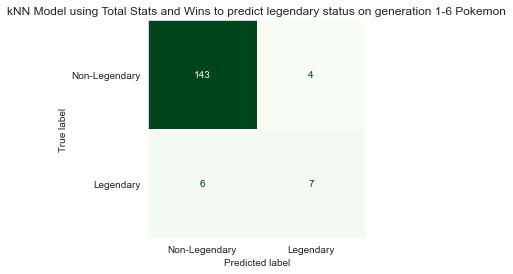

In [45]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats_and_wins, 
                                      X_test, 
                                      y_test,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('kNN Model using Total Stats and Wins to predict legendary status on generation 1-6 Pokemon');

The model is very good at classifying non-legendary pokemon correctly, but is not as good at doing so for legendary pokemon.  Overall, precision, recall, and f1-score are all around 0.93-0.94.  The model seems heavily biased towards predicting a Pokémon will be non-legendary, with 149 out of 160 predictions (93.125%) being non-legendary.

I'm curious to see many Pokémon are legendary in the entire dataset for generation 1-7.  Let's investigate.

In [46]:
pkmn_join['Legendary'].value_counts(normalize=True)

False    0.91875
True     0.08125
Name: Legendary, dtype: float64

Because there aren't that many legendary Pokémon in the game, an overwhelming majority are non-legendary (91.875%).  Knowing this, one could achieve roughly 92% accuracy on predictions by simply guessing non-legendary on any new Pokémon.

The kNN model we constructed using `Total Stats` and `Wins` is only doing slightly better than that with roughly 94% accuracy.

Let's see how our other top kNN model performs.

### Model: Total stats

In [47]:
X_train, X_test, y_train, y_test = train_test_split(total_stats, 
                                                    target_df, 
                                                    test_size=0.2, 
                                                    random_state=6)

#### Fit and train the model, then generate predictions

In [48]:
knn_total_stats.set_params(n_neighbors=5)
knn_total_stats.fit(X_train, y_train)
y_preds = knn_total_stats.predict(X_test)

#### Check performance metrics

In [49]:
# knn_total_stats_score = knn_total_stats.score(X_test, 
#                                               y_test)
accuracy = accuracy_score(y_test, 
                          y_preds)
f1 = f1_score(y_test, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_test, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_test, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [50]:
accuracy, f1, precision, recall

(0.9625, 0.9572499999999999, 0.9639705882352942, 0.9625)

In [51]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       147
        True       1.00      0.54      0.70        13

    accuracy                           0.96       160
   macro avg       0.98      0.77      0.84       160
weighted avg       0.96      0.96      0.96       160



#### Check confusion matrix

In [52]:
# plot_confusion_matrix(knn_total_stats, X_test, y_test, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

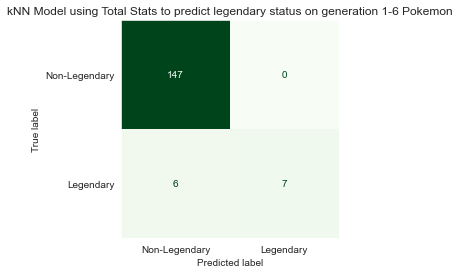

In [53]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats, 
                                      X_test, 
                                      y_test,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('kNN Model using Total Stats to predict legendary status on generation 1-6 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/knn_gen_16.png", bbox_inches="tight");

This model performs about the same as the previous one but is even more biased to predicting a new Pokémon as non-legendary, with 153 out of 160 predicted as being non-legendary (95.625%).

Let's see how well both of these models predict on real testing data from a newer Pokémon generation.

## Checking performance on completely new pokemon from generation 7

In [54]:
complete = pd.read_csv("./pokemon_data/complete/pokemon_complete.csv")

In [55]:
gen_7 = complete.loc[complete['generation']==7, 
                     ['pokedex_number', 
                      'name', 
                      'attack', 
                      'defense', 
                      'hp', 
                      'sp_attack', 
                      'sp_defense', 
                      'speed', 
                      'generation', 
                      'is_legendary']
                    ]

In [56]:
gen_7['total_stats'] = gen_7[['attack', 
                              'defense', 
                              'hp', 
                              'sp_attack', 
                              'sp_defense', 
                              'speed']].sum(axis=1)

In [57]:
gen_7['is_legendary'].value_counts(normalize=True)

0    0.7875
1    0.2125
Name: is_legendary, dtype: float64

Generation 7 is interesting because there's a much lower proportion of non-legendary pokemon in this generation (78.75%) as compared to only about 93% from generation 1-6 combined.  

Given that the kNN models that were constructed earlier are biased towards predicting non-legendary, I imagine we'll see a pretty significant hit on accuracy and other metrics on the new generation 7 data.

In [58]:
gen_7_total_stats = gen_7.loc[:, 'total_stats']
gen_7_total_stats = np.array(gen_7_total_stats).reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(gen_7_total_stats)
gen_7_total_scaled = scaler.transform(gen_7_total_stats)
#gen_7.loc[:, 'total_stats'] = gen_7_total_scaled
X_gen_7 = gen_7_total_scaled

In [59]:
gen_7.loc[:, 'is_legendary'] = gen_7.loc[:, 'is_legendary'].astype('bool')
y_gen_7 = gen_7.loc[:, 'is_legendary']

y_preds = knn_total_stats.predict(X_gen_7)

In [60]:
# gen_7_total_stats_score = knn_total_stats.score(X_gen_7, 
#                                                 y_gen_7)
accuracy = accuracy_score(y_gen_7, 
                          y_preds)
f1 = f1_score(y_gen_7, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_gen_7, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_gen_7, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [61]:
accuracy, f1, precision, recall

(0.8125, 0.7484602463605823, 0.8485576923076923, 0.8125)

In [62]:
print(classification_report(y_gen_7, y_preds))

              precision    recall  f1-score   support

       False       0.81      1.00      0.89        63
        True       1.00      0.12      0.21        17

    accuracy                           0.81        80
   macro avg       0.90      0.56      0.55        80
weighted avg       0.85      0.81      0.75        80



All of our metrics have decreased, with 81.25% accuracy.  Given that our data set had about 78% non-legendary Pokémon in it, this makes sense for a model that has a strong tendency to predict non-legendary.

In [63]:
# plot_confusion_matrix(knn_total_stats, X_gen_7, y_gen_7, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

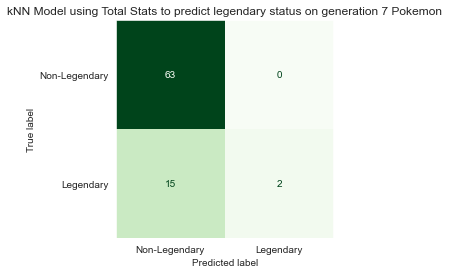

In [64]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats, 
                                      X_gen_7, 
                                      y_gen_7,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('kNN Model using Total Stats to predict legendary status on generation 7 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/knn_gen_7.png", bbox_inches="tight");

Looking at the confusion matrix, we see that the model has predicted all but 2 Pokémon as being non-legendary.  Since a larger than usual proportion of Pokémon are legendary in generation 7, the kNN model that predominantly predict non-legendary is seeing a heavy hit on its accuracy and is probably not a very useful model to use.  

Moving on.

# Logistic regression
Because we already have a reasonable idea of which features are most correlated with a Pokémon being legendary, I'll create a logistic regression model that uses `Total Stats` and check its performance on new generation 7 Pokémon data, then compare against the kNN model from earlier.

## `Total Stats`

In [65]:
X = pkmn_join[['Total Stats']]
y = target_df

sm_log_reg_model = sm.Logit(y, X)
sm_log_reg_fit = sm_log_reg_model.fit()

Optimization terminated successfully.
         Current function value: 0.380847
         Iterations 6


In [66]:
sm_log_reg_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Legendary   No. Observations:                  800
Model:                          Logit   Df Residuals:                      799
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Mar 2023   Pseudo R-squ.:                 -0.3514
Time:                        21:39:24   Log-Likelihood:                -304.68
converged:                       True   LL-Null:                       -225.45
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Total Stats    -0.0045      0.000    -17.417      0.000      -0.005      -0.004
===============================================================================
"""

The summary output for the logistic regression model shows that `Total Stats` is a statistically significant predictor with a P-value of $\approx 0$

The coefficient of -0.0045 means that for a one unit increase in `Total Stats` we expect to see a decrease of 0.0045 in the log odds for predicting a Pokémon as non-legendary.  In other words, Pokémon with higher total stats are less likely to be non-legendary.

In [67]:
sk_log_reg_model = LogisticRegression()
sk_log_reg_fit = sk_log_reg_model.fit(X, y)

y_prob_non_legendary = sk_log_reg_fit.predict_proba(X)

log_reg_proba_df = pd.concat([pkmn_join[['Total Stats', 'Legendary']],
                             pd.Series(y_prob_non_legendary[:, 0],
                             index=np.arange(1, 801),
                             name='Predicted Probability')], axis=1)

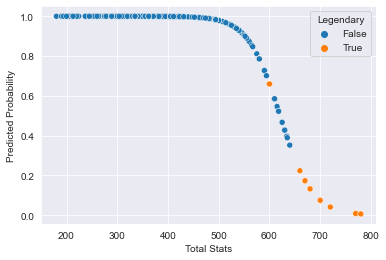

In [68]:
sns.scatterplot(x='Total Stats',
                y='Predicted Probability',
                data=log_reg_proba_df,
                hue='Legendary');

The graph above provides a nice visual representation of what the -0.0045 coefficient from the summary above represents.  We can see that as `Total Stats` increases, the predicted probabilities of a Pokémon being non-legendary decrease.  This makes sense as most of the Pokémon with the highest `Total Stats` are legendary.

In [69]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

sk_log_reg_model = LogisticRegression()

sk_log_reg_scores = cross_val_score(sk_log_reg_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [70]:
print("Stratified k-Fold Repeated Cross Validation")
print("--------------------------------")
print(F"Average Testing Accuracy: {sk_log_reg_scores.mean():.3f}")
print(F"Average Testing Error: {1 - sk_log_reg_scores.mean():.3f}")
print(F"Std Dev: {sk_log_reg_scores.std():.3f}")

Stratified k-Fold Repeated Cross Validation
--------------------------------
Average Testing Accuracy: 0.934
Average Testing Error: 0.066
Std Dev: 0.023


To accurately estimate the testing error of the model, we use stratified k-fold repeated cross validation.  This will split the data set into equal "folds", train a model using all but one fold, then test performance on the last remaining fold.  In our case, with `n_splits = 10`, ten different models will be created using a different 9/10 of the data set and each model's testing performance will be evaluated on the last 1/10 of the data that was not used for training.  This process will be repeated three times (`n_repeats=3`), each time generating a new and unique set of ten folds, meaning that 30 different models will be trained and their performance evaluated.

Because there's a large class imbalance between legendary (8%) and non-legendary (92%) Pokémon in generation 1-6, using `RepeatedStratifiedKFold` is preferred over `RepeatedKFold`.  It will ensure that every fold maintains the same proportion of observations between legendary and non-legendary, which is important because we want our model to be trained on and tested against data that most closely resembles the true population, where large class imbalances are present.  

After performing the cross validation, we can get an estimate of what our testing error will be for the logistic regression model.  On average, we expect roughly 93% accuracy, with a standard deviation of 2.5%.

## Gen 7 Testing

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)

sk_log_reg_fit = sk_log_reg_model.fit(X_train, y_train)

In [72]:
sk_log_reg_gen_7_preds = sk_log_reg_fit.predict(np.array(gen_7['total_stats']).reshape(-1,1))

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_gen_7, sk_log_reg_gen_7_preds)
test_error = 1 - accuracy
print(F"Gen 7 Accuracy: {accuracy:.3f}")
print(F"Gen 7 error: {test_error:.3f}")

Gen 7 Accuracy: 0.812
Gen 7 error: 0.188


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


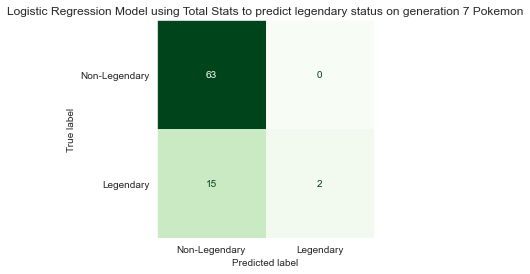

In [73]:
ConfusionMatrixDisplay.from_estimator(sk_log_reg_fit, 
                                      np.array(gen_7['total_stats']).reshape(-1,1), 
                                      y_gen_7,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('Logistic Regression Model using Total Stats to predict legendary status on generation 7 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/log_reg_gen_7.png", bbox_inches="tight");

Using logistic regression on the generation 7 data produces the exact same predictions as our kNN model and we see the same accuracy (82%).  The logistic regression model is also heavily biased towards predicting a Pokémon is non-legendary. 

Perhaps there are other models out there that are more apt to handle this class imbalance between legendary and non-legendary, however there may be a more direct approach instead. Using a technique known as SMOTE (**S**ynthetic **M**inority **O**ver-Sampling **TE**chnique), we can over-sample the minority class and/or under-sample the majority class, to produce a data set that is more balanced and easier to train a model on.  

By going to the source and dealing with the class imbalance in the data itself, maybe kNN or logistic regression models will start to be viable.

# Overcoming the obstacle using SMOTE (Synthetic Minority Over Sampling Technique) with Imbalanced Learn

## kNN again

Using SMOTE, we can over-sample the minority class to produce a dataset which eliminates the class imbalance.  Before using SMOTE, there was a 8% / 92% split between legendary and non-legendary Pokémon, however we can control what ratio we'd like to see afterwards using a parameter called sampling_strategy.  If no value is passed to this parameter, it defaults to creating a perfect 50% / 50% split between classes.


Afterwards, a kNN model can be built using the transformed dataset and we can estimate the testing performance using cross validation.

### Evaluating model performance after SMOTE

First I'll define a pipeline based on the following steps:
1) Use SMOTE to over-sample the minority class (legendary)
2) Fit a kNN model using the over-sampled data

Next, I'll define a RepeatedStratifiedKFold cross-validation strategy, that will divide the dataset into ten stratified folds and this process will repeat three times.  The folds are stratified such that each will maintain the same ratio of non-legendary to legendary Pokémon.  

For each of the three times this process happens, ten different models will be made.  Each model will be trained on a different combination of nine of the ten folds and tested on the remaining one fold of the data.  We can then average the performance of all 30 models to get an estimate of the model's performance on new data in the future. 

When the pipeline and RepeatedStratifiedKFold strategy are combined using the cross_validate() function from SKlearn:
1) The data will be split into 10 stratified folds.  Nine of the folds will be transformed using SMOTE and used as a training set while the remaining fold will not be transformed and considered the testing set.
2) A kNN model will be trained on the transformed training data
3) The model's performance will be evaluated on un-transformed testing data and recorded

Afterwards, I'll average testing performance from all 30 kNN models.

In [74]:
steps = [('over', imblearn.over_sampling.SMOTE(random_state=42)), ('model', KNeighborsClassifier())]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

In [75]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

knn_smote = cross_validate(pipeline, 
                            X, 
                            y, 
                            scoring={'ROC_AUC':'roc_auc',
                                     'acc':'accuracy'},
                            cv=cv, 
                            n_jobs=-1)

In [76]:
print("k-Fold Repeated Cross Validation")
print("--------------------------------")
print(F"Average testing ROC AUC: {knn_smote['test_ROC_AUC'].mean():.3f}")
print(F"Std Dev: {knn_smote['test_ROC_AUC'].std():.3f}")
print()
print(F"Average testing Accuracy: {knn_smote['test_acc'].mean():.3f}")
print(F"Std Dev: {knn_smote['test_acc'].std():.3f}")

k-Fold Repeated Cross Validation
--------------------------------
Average testing ROC AUC: 0.890
Std Dev: 0.093

Average testing Accuracy: 0.958
Std Dev: 0.022


Using SMOTE, the average testing accuracy (95.8%) is close to the testing accuracy of kNN model from earlier (96.25%).

Unfortunately this isn't an improvement, however its recommended to use under-sampling of the majority class in conjuction with over-sampling of the minority class, to see the best performance.  

Let's try.

### Evaluating model performance after using both over and under-sampling techniques

I'll begin by defining a new pipeline that does the same as the last, however it will also under-sample the majority class.  

Furthermore, I'll try sampling_strategy = 0.1 for the over-sampling strategy.  This means that first, minority classes of the data set will be over-sampled such that new synthetically created minority observations are added to the dataset until there are 1 minority observation for every 10 majority observations (1/10 = 0.1).  

Next, using sampling_strategy = 0.5 for the under-sampling strategy means that observations from the majority class will be removed until there are 1 minority observation for ever 2 majority observation (1/2 = 0.5).

Using the same cross validation strategy as last time, we can estimate the performance of this new kNN model after the over and under-sampling.

In [77]:
knn_model = KNeighborsClassifier()
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=42)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under), ('model', knn_model)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

In [78]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

knn_smote = cross_validate(pipeline, 
                           X, 
                           y, 
                           scoring={'ROC_AUC':'roc_auc',
                                    'acc':'accuracy'},
                           cv=cv, 
                           n_jobs=-1)

In [79]:
print("k-Fold Repeated Cross Validation")
print("--------------------------------")
print(F"Average testing ROC AUC: {knn_smote['test_ROC_AUC'].mean():.3f}")
print(F"Std Dev: {knn_smote['test_ROC_AUC'].std():.3f}")
print()
print(F"Average testing accuracy: {knn_smote['test_acc'].mean():.3f}")
print(F"Std Dev: {knn_smote['test_acc'].std():.3f}")

k-Fold Repeated Cross Validation
--------------------------------
Average testing ROC AUC: 0.962
Std Dev: 0.042

Average testing accuracy: 0.945
Std Dev: 0.022


Including the under-sampling strategy boosts the average ROC AUC up to 0.962 compared to the 0.890 when using SMOTE alone.  This is significant because with AUC of 0.962, the model will correctly distinguish between classes 96.2% of the time.  

Not much change in average testing accuracy though, it remains roughly the same at (94.5%).

This is a step in the right direction, but perhaps after tuning the over_sampling and under_sampling strategies, the model will perform better.  Let's see.

#### Hyperparameter tuning - Adjusting over_sampling and under_sampling strategies

For the *over-sampling* strategy, there are two main parameters to tune:
1) k_neighbors: this is the number of neighbors used when constructing the transformed sample.
2) sampling_strategy: this corresponds to the desired ratio of the number of observations in the minority class to the number of observations in the majority class, after **over**-sampling. (num_minority/num_majority)

For *under-sampling*, we can tune the sampling strategy as well:
1) sampling_strategy: this corresponds to the desired ratio of the number of observations in the minority class to the number of observations in the majority class, after **under**-sampling. (num_minority/num_majority)

##### Tuning k_neighbors

In [80]:
k_values = np.arange(1,11)

for k in k_values:
    knn_model = KNeighborsClassifier()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, k_neighbors=k, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('over', over), ('under', under), ('model', knn_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    knn_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = knn_smote.mean()
    print(F"> k={k}, Mean ROC AUC: {score:.3f}")

> k=1, Mean ROC AUC: 0.959
> k=2, Mean ROC AUC: 0.963
> k=3, Mean ROC AUC: 0.959
> k=4, Mean ROC AUC: 0.960
> k=5, Mean ROC AUC: 0.962
> k=6, Mean ROC AUC: 0.963
> k=7, Mean ROC AUC: 0.960
> k=8, Mean ROC AUC: 0.963
> k=9, Mean ROC AUC: 0.960
> k=10, Mean ROC AUC: 0.961


The average ROC AUC doesn't change much when adjusting for different values of k, however we see the highest average ROC AUC of 0.963 when k=2, 6, and 8.  

For now, I plan to go with k=6 because it achieves the highest ROC AUC and is closest to the default k value of 5.

##### Tuning sampling_strategy for over-sampling

In [81]:
over_sampling_strategy = np.arange(0.1, 0.51, 0.1)

for num in over_sampling_strategy:
    knn_model = KNeighborsClassifier()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=num, k_neighbors=6, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('over', over), ('under', under), ('model', knn_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    knn_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = knn_smote.mean()
    print(F"> over_sampling_strategy={num}, Mean ROC AUC: {score:.3f}")

> over_sampling_strategy=0.1, Mean ROC AUC: 0.963
> over_sampling_strategy=0.2, Mean ROC AUC: 0.883
> over_sampling_strategy=0.30000000000000004, Mean ROC AUC: 0.867
> over_sampling_strategy=0.4, Mean ROC AUC: 0.870
> over_sampling_strategy=0.5, Mean ROC AUC: 0.855


Increasing the sampling_strategy seems to decrease our average ROC AUC.  The best performance is when sampling_strategy = 0.1.  

This means that after the over_sampling strategy is employed and new synthetic observations are added to the dataset, the ratio between the minority and majority classes will be 0.1 or 1 minority observation for 10 observations.

##### Tuning sampling_strategy for under-sampling

In [82]:
under_sampling_strategy = np.arange(0.1, 1.01, 0.1)

for num in under_sampling_strategy:
    knn_model = KNeighborsClassifier()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, k_neighbors=6, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=num, random_state=42)
    steps = [('over', over), ('under', under), ('model', knn_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    knn_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = knn_smote.mean()
    print(F"> over_sampling_strategy={num}, Mean ROC AUC: {score:.3f}")

> over_sampling_strategy=0.1, Mean ROC AUC: 0.880
> over_sampling_strategy=0.2, Mean ROC AUC: 0.886
> over_sampling_strategy=0.30000000000000004, Mean ROC AUC: 0.904
> over_sampling_strategy=0.4, Mean ROC AUC: 0.966
> over_sampling_strategy=0.5, Mean ROC AUC: 0.963
> over_sampling_strategy=0.6, Mean ROC AUC: 0.969
> over_sampling_strategy=0.7000000000000001, Mean ROC AUC: 0.968
> over_sampling_strategy=0.8, Mean ROC AUC: 0.965
> over_sampling_strategy=0.9, Mean ROC AUC: 0.965
> over_sampling_strategy=1.0, Mean ROC AUC: 0.970


Increasing sampling_strategy has a tendency to increase the average ROC AUC and we see the highest ROC AUC of 0.970 when sampling_strategy is 1.0.  In close second is when sampling_strategy is 0.6.

### Building the model

#### Train/Test Split

First I'll create a train/test split of the data, then define a data pipeline that will first over-sample the minority class, the under-sample the majority class in the training data.  Using the transformed training data, I'll build a kNN model and check its performance on un-transformed testing data.

In [83]:
knn_model = KNeighborsClassifier()
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, k_neighbors=6, random_state=42)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=42)
steps = [('over', over), ('under', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

X_over_under_train, y_over_under_train = pipeline.fit_resample(X_train, y_train)

knn_fit = knn_model.fit(X_over_under_train, y_over_under_train)

knn_test_preds = knn_fit.predict(X_test)

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_test, knn_test_preds)
test_error = 1 - accuracy
print(F"Testing Accuracy: {accuracy:.3f}")
print(F"Testing error: {test_error:.3f}")

Testing Accuracy: 0.925
Testing error: 0.075


At first glance, the model appears similar to the one without using any over or under-sampling strategies with 92.5% accuracy.

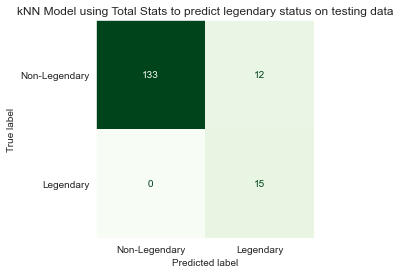

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test, 
                                      knn_test_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('kNN Model using Total Stats to predict legendary status on testing data')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/knn_testing_after_smote.png", bbox_inches="tight");

However, if we look at the predictions themselves, the model correctly predicted every non-legendary Pokémon and it was less biased towards predicting a Pokémon was non-legendary.  This is starting to look better.

Let's see if the model can adapt to completely new Pokémon again by testing using data from generation 7 Pokémon.

#### Generation 7 Predictions

In [85]:
knn_gen_7_preds = knn_fit.predict(np.array(gen_7['total_stats']).reshape(-1,1))

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_gen_7, knn_gen_7_preds)
test_error = 1 - accuracy
print(F"Generation 7 Accuracy: {accuracy:.3f}")
print(F"Generation 7 error: {test_error:.3f}")

Generation 7 Accuracy: 0.938
Generation 7 error: 0.062


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


More good news.  There's a fairly significant boost in accuracy compared to the kNN model from earlier.  Now accuracy is 93.8%, up from 81.25%.

This is a huge win because if you recall, the kNN model from before was heavily biased towards predicting a Pokémon as non-legendary.  Because the model would predict non-legendary nearly every time, its accuracy of 81.25% wasn't much higher than the proportion of non-legendary Pokémon in generation 7, which was roughly 79%.  

The new model trained on over and under-sampled data is adapting much better to new data.

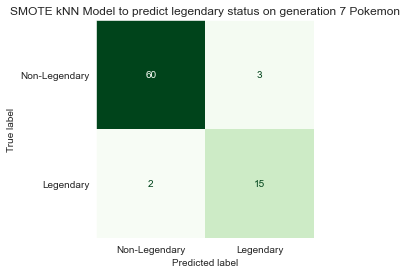

In [86]:
ConfusionMatrixDisplay.from_predictions(y_gen_7, 
                                      knn_gen_7_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('SMOTE kNN Model to predict legendary status on generation 7 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/knn_gen_7_after_smote.png", bbox_inches="tight");

Looking at the predictions, the model is correctly classifying both non-legendary and legendary Pokémon almost all of the time.  Only 5 observations were incorrectly classified and we no longer see the bias towards predicting non-legendary.

How will the model perform on generation 8 Pokémon?

#### Generation 8 Predictions

In [87]:
all_generations = pd.read_csv("./pokemon_data/full_pokedex.csv", index_col=0)
gen_8 = all_generations.loc[all_generations['generation']==8, :].copy()

In [88]:
gen_8.rename(columns={'total_points':'total_stats'}, inplace=True)

In [89]:
y_gen_8 = gen_8['is_legendary'].map({1:True, 0:False})

In [90]:
y_gen_8.value_counts(normalize=True)

False    0.833333
True     0.166667
Name: is_legendary, dtype: float64

In [91]:
knn_gen_8_preds = knn_fit.predict(np.array(gen_8['total_stats']).reshape(-1,1))

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_gen_8, knn_gen_8_preds)
test_error = 1 - accuracy
print(F"Generation 8 Accuracy: {accuracy:.3f}")
print(F"Generation 8 error: {test_error:.3f}")

Generation 8 Accuracy: 0.917
Generation 8 error: 0.083


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


The new model continues to perform well and still has great accuracy (91.7%) even on generation 8 Pokémon.  Because roughly 83% of Pokémon in generation 8 are non-legendary, the new model is performing a good bit better than a naive model, which always predicts non-legendary.

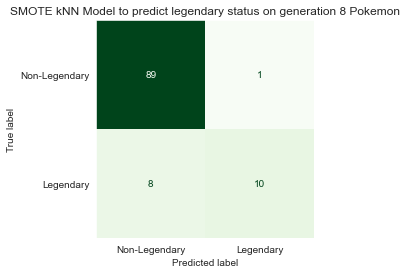

In [92]:
ConfusionMatrixDisplay.from_predictions(y_gen_8, 
                                      knn_gen_8_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('SMOTE kNN Model to predict legendary status on generation 8 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/knn_gen_8_after_smote.png", bbox_inches="tight");

Looking at the predictions, only 9 observations were misclassified and the model is doing a good job of identifying both legendary and non-legendary Pokémon.  

### Conclusion

For now, this kNN model appears great and because it's our only reasonably performing model so far, it's the best one I have.

Let's see what happens if we try logistic regression using the over and under-sampling techniques from earlier.

## Logistic Regression again

### Evaluating model performance after SMOTE

Like before, I'll define a data pipeline  that will over_sample the minority class and perform repeated stratified kfold cross validation on logistic regression models to estimate accuracy on testing data.

In [93]:
steps = [('over', imblearn.over_sampling.SMOTE(random_state=42)), ('model', LogisticRegression())]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

In [94]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

sk_log_reg_smote = cross_validate(pipeline, 
                                  X, 
                                  y, 
                                  scoring={'ROC_AUC':'roc_auc',
                                           'acc':'accuracy'},
                                  cv=cv, 
                                  n_jobs=-1)

In [95]:
print("k-Fold Repeated Cross Validation")
print("--------------------------------")
print(F"Average testing ROC AUC: {sk_log_reg_smote['test_ROC_AUC'].mean():.3f}")
print(F"Std Dev: {sk_log_reg_smote['test_ROC_AUC'].std():.3f}")
print()
print(F"Average testing accuracy: {sk_log_reg_smote['test_acc'].mean():.3f}")
print(F"Std Dev: {sk_log_reg_smote['test_acc'].std():.3f}")

k-Fold Repeated Cross Validation
--------------------------------
Average testing ROC AUC: 0.970
Std Dev: 0.018

Average testing accuracy: 0.932
Std Dev: 0.029


The logistic regression model after smote has a really solid ROC AUC of 0.970 and accuracy of 93.2%.  The accuracy is about the same as our logistic regression model from earlier, but we haven't attempted an under-sampling strategy yet.

### Evaluating model performance after using both over and under-sampling techniques

In [96]:
sk_log_reg_model = LogisticRegression()
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=42)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under), ('model', sk_log_reg_model)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

In [97]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

sk_log_reg_smote = cross_validate(pipeline, 
                                  X, 
                                  y, 
                                  scoring={'ROC_AUC':'roc_auc',
                                           'acc':'accuracy'},
                                  cv=cv, 
                                  n_jobs=-1)

In [98]:
print("k-Fold Repeated Cross Validation")
print("--------------------------------")
print(F"Average testing ROC AUC: {sk_log_reg_smote['test_ROC_AUC'].mean():.3f}")
print(F"Std Dev: {sk_log_reg_smote['test_ROC_AUC'].std():.3f}")
print()
print(F"Average testing accuracy: {sk_log_reg_smote['test_acc'].mean():.3f}")
print(F"Std Dev: {sk_log_reg_smote['test_acc'].std():.3f}")

k-Fold Repeated Cross Validation
--------------------------------
Average testing ROC AUC: 0.970
Std Dev: 0.018

Average testing accuracy: 0.937
Std Dev: 0.029


After employing both an over and under sampling strategy, we still see an average ROC AUC of 0.970, but the testing accuracy has risen slightly to 93.7%

If we attempt some hyperparameter tuning, perhaps this will improve more.

#### Hyperparameter tuning

##### Tuning k_neighbors

In [99]:
k_values = np.arange(1,8)

for k in k_values:
    sk_log_reg_model = LogisticRegression()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, k_neighbors=k, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('over', over), ('under', under), ('model', sk_log_reg_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    sk_log_reg_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = sk_log_reg_smote.mean()
    print(F"> k={k}, Mean ROC AUC: {score:.3f}")

> k=1, Mean ROC AUC: 0.970
> k=2, Mean ROC AUC: 0.970
> k=3, Mean ROC AUC: 0.970
> k=4, Mean ROC AUC: 0.970
> k=5, Mean ROC AUC: 0.970
> k=6, Mean ROC AUC: 0.970
> k=7, Mean ROC AUC: 0.970


Because ROC AUC stays the same for all values of k, I'll stick with the default value of k=5.

##### Tuning sampling_strategy for over-sampling

In [100]:
over_sampling_strategy = np.arange(0.1, 0.51, 0.1)

for num in over_sampling_strategy:
    sk_log_reg_model = LogisticRegression()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=num, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('over', over), ('under', under), ('model', sk_log_reg_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    sk_log_reg_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = sk_log_reg_smote.mean()
    print(F"> over_sampling_strategy = {num}, Mean ROC AUC: {score:.3f}")

> over_sampling_strategy = 0.1, Mean ROC AUC: 0.970
> over_sampling_strategy = 0.2, Mean ROC AUC: 0.970
> over_sampling_strategy = 0.30000000000000004, Mean ROC AUC: 0.970
> over_sampling_strategy = 0.4, Mean ROC AUC: 0.970
> over_sampling_strategy = 0.5, Mean ROC AUC: 0.970


Adjusting the sampling_strategy for over-sampling doesn't increase ROC AUC, so I'll stick with a lower level of 0.1 and keep the ratio of non-legendary to legendary Pokémon close to what's found in the original dataset.  

Remember, originally the dataset was about 8% legendary to 92% non-legendary, which would correspond to a sampling strategy of about 0.0870 (0.08 / 0.92 = 0.0870).  

##### Tuning sampling_strategy for under-sampling

In [101]:
under_sampling_strategy = np.arange(0.1, 1.01, 0.1)

for num in under_sampling_strategy:
    sk_log_reg_model = LogisticRegression()
    over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=42)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=num, random_state=42)
    steps = [('over', over), ('under', under), ('model', knn_model)]
    pipeline = imblearn.pipeline.Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    knn_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = knn_smote.mean()
    print(F"> under_sampling_strategy={num}, Mean ROC AUC: {score:.3f}")

> under_sampling_strategy=0.1, Mean ROC AUC: 0.875
> under_sampling_strategy=0.2, Mean ROC AUC: 0.903
> under_sampling_strategy=0.30000000000000004, Mean ROC AUC: 0.912
> under_sampling_strategy=0.4, Mean ROC AUC: 0.950
> under_sampling_strategy=0.5, Mean ROC AUC: 0.962
> under_sampling_strategy=0.6, Mean ROC AUC: 0.967
> under_sampling_strategy=0.7000000000000001, Mean ROC AUC: 0.974
> under_sampling_strategy=0.8, Mean ROC AUC: 0.970
> under_sampling_strategy=0.9, Mean ROC AUC: 0.965
> under_sampling_strategy=1.0, Mean ROC AUC: 0.969


Increasing the sampling_strategy for under_sampling tends to have an increase on the ROC AUC.  The highest ROC AUC of 0.974 occurs when sampling_strategy is 0.7

### Building the model

#### Train/Test Split

In [102]:
sk_log_reg_model = LogisticRegression()
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=42)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.7, random_state=42)
steps = [('over', over), ('under', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

X_over_under_train, y_over_under_train = pipeline.fit_resample(X_train, y_train)

sk_log_reg_fit = sk_log_reg_model.fit(X_over_under_train, y_over_under_train)

sk_log_reg_test_preds = sk_log_reg_fit.predict(X_test)

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_test, sk_log_reg_test_preds)
test_error = 1 - accuracy
print(F"Testing Accuracy: {accuracy:.3f}")
print(F"Testing error: {test_error:.3f}")

Testing Accuracy: 0.925
Testing error: 0.075


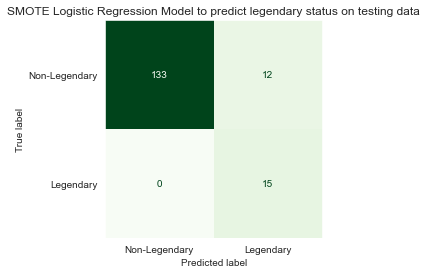

In [103]:
ConfusionMatrixDisplay.from_predictions(y_test, 
                                      sk_log_reg_test_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('SMOTE Logistic Regression Model to predict legendary status on testing data')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/log_reg_testing_after_smote.png", bbox_inches="tight");

The logistic regression model after over and under-sampling produces the exact same accuracy and exact same predictions as the kNN model on generation 1-6 Pokémon.  

#### Generation 7 Predictions

In [104]:
sk_log_reg_gen_7_preds = sk_log_reg_fit.predict(np.array(gen_7['total_stats']).reshape(-1,1))

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_gen_7, sk_log_reg_gen_7_preds)
test_error = 1 - accuracy
print(F"Generation 7 Accuracy: {accuracy:.3f}")
print(F"Generation 7 error: {test_error:.3f}")

Generation 7 Accuracy: 0.938
Generation 7 error: 0.062


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


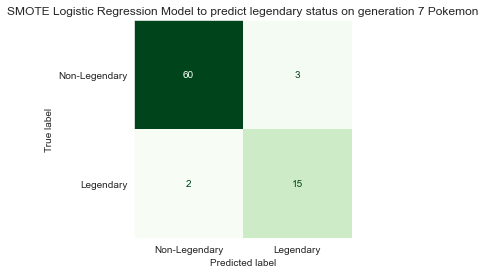

In [105]:
ConfusionMatrixDisplay.from_predictions(y_gen_7, 
                                      sk_log_reg_gen_7_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('SMOTE Logistic Regression Model to predict legendary status on generation 7 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/log_reg_gen_7_after_smote.png", bbox_inches="tight");

Same accuracy and predictions on generation 7 Pokémon too.

#### Generation 8 Predictions

In [106]:
sk_log_reg_gen_8_preds = sk_log_reg_fit.predict(np.array(gen_8['total_stats']).reshape(-1,1))

# lr_preds
# preds = log_reg_fit_auto.predict(X_test_imp_features)
# pred_mpg01 = np.where(preds <= 0.5, 0, 1)

accuracy = accuracy_score(y_gen_8, sk_log_reg_gen_8_preds)
test_error = 1 - accuracy
print(F"Generation 8 Accuracy: {accuracy:.3f}")
print(F"Generation 8 error: {test_error:.3f}")

Generation 8 Accuracy: 0.917
Generation 8 error: 0.083


/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


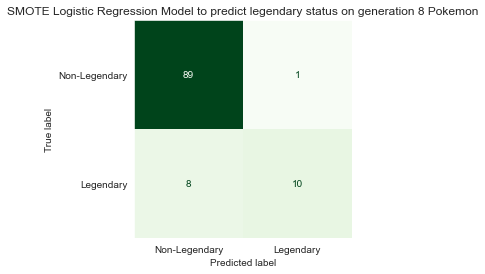

In [107]:
ConfusionMatrixDisplay.from_predictions(y_gen_8, 
                                      sk_log_reg_gen_8_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False)
plt.grid(False)
plt.title('SMOTE Logistic Regression Model to predict legendary status on generation 8 Pokemon')
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/log_reg_gen_8_after_smote.png", bbox_inches="tight");

Once again, the logistic regression model has the same accuracy as the kNN model on generation 8 Pokémon.

### Conclusion

Right now, the logistic regression and kNN models are performing reasonably well after using over and under-sampling techniques, however neither model performs better than the other.  Both models are also relatively simple and would be good choices to use for predicting whether a Pokémon is legendary.

Other models may perform better and I plan to do more investigating in the future, but for now I'll stop searching.

# The end

# Some plots

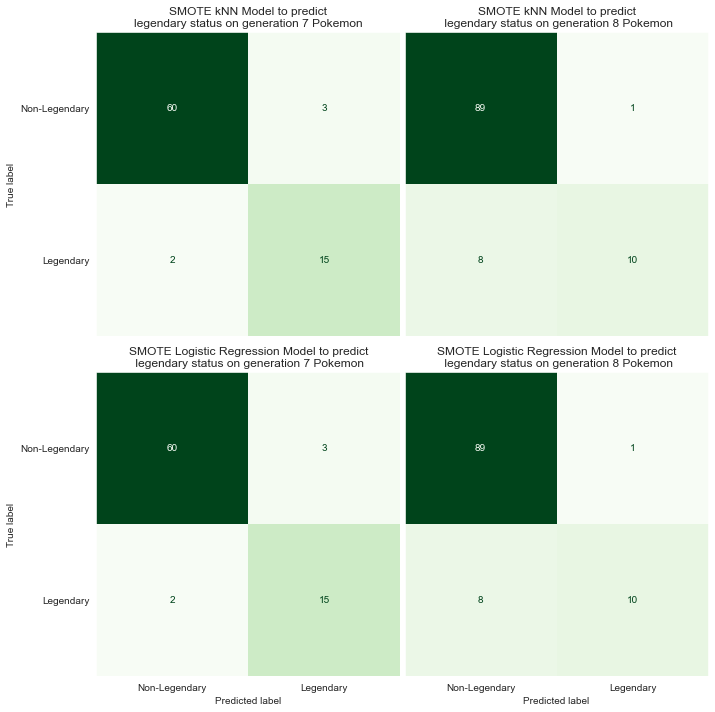

In [108]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

ConfusionMatrixDisplay.from_predictions(y_gen_7, 
                                      knn_gen_7_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False,
                                       ax=ax[0,0])
ax[0,0].grid(False)
ax[0,0].set_title('SMOTE kNN Model to predict\nlegendary status on generation 7 Pokemon')
ax[0,0].get_xaxis().set_visible(False)

ConfusionMatrixDisplay.from_predictions(y_gen_8, 
                                      knn_gen_8_preds,
                                      cmap="Greens",
                                     colorbar=False, ax=ax[0,1])
ax[0,1].grid(False)
ax[0,1].set_title('SMOTE kNN Model to predict\n legendary status on generation 8 Pokemon')
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)

ConfusionMatrixDisplay.from_predictions(y_gen_7, 
                                      sk_log_reg_gen_7_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False,
                                       ax=ax[1,0])
ax[1,0].grid(False)
ax[1,0].set_title('SMOTE Logistic Regression Model to predict\n legendary status on generation 7 Pokemon')


ConfusionMatrixDisplay.from_predictions(y_gen_8, 
                                      sk_log_reg_gen_8_preds,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False,
                                       ax=ax[1,1])
ax[1,1].grid(False)
ax[1,1].set_title('SMOTE Logistic Regression Model to predict\n legendary status on generation 8 Pokemon')
ax[1,1].get_yaxis().set_visible(False)


plt.tight_layout()

plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/pokemon_classifier/smote_summary.png", bbox_inches="tight");